# ML4HPC: Ensemble of Forecasters

### Team Members:
- Luca Venerando Greco
- Bice Marzagora
- Elia Vaglietti


### Importing Libraries

In this notebook, we start by importing several essential libraries that are used throughout the workflow:

- `os`: Provides functions for interacting with the operating system, such as creating directories and handling file paths.
- `sys`: Provides access to some variables used or maintained by the Python interpreter and to functions that interact strongly with the interpreter.
- `matplotlib.pyplot`: A plotting library used for creating static, animated, and interactive visualizations in Python.
- `numpy`: A fundamental package for scientific computing with Python, used for working with arrays and matrices.
- `time`: Provides various time-related functions.
- `tqdm`: A library for creating progress bars and progress meters.

These libraries are crucial for tasks such as data manipulation, visualization, and managing the execution of jobs in a high-performance computing environment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import jax
import jax.numpy as jnp
from jax import grad
import time
import os
import tqdm

2024-12-02 11:50:57.791939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 11:50:57.798214: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 11:50:57.812778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733136657.836609 1568076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733136657.843252 1568076 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:50:57.872296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Directory Setup and Job Configuration

We now set up the necessary directories and define the job configurations. Specifically, we create folders for storing charts, data, and logs if they do not already exist. We also define the number of forecasters and nodes for different scaling tests.

If no new data is needed, set the `GENERATE_DATA` variable to `False` to skip the data generation step.


In [ ]:
current_dir = os.getcwd()

charts_folder = "charts"
data_folder = "data"
logs_folder = "logs"

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

ten_nodes = 10
strong_scaling_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test
weak_scaling_nodes   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of nodes to test

n_runs = 30

GENERATE_DATA = False

### Job Submission Function

We define a function `submit_job` that handles the submission of jobs to the scheduler. This function takes the number of nodes, the number of forecasters, and a job name as input parameters. It creates the necessary directories for storing data and logs, reads a template launch script, formats it with the provided parameters, writes the formatted script to a file, and submits the job using the `sbatch` command.

In [ ]:
def submit_job(num_nodes, job_name):
    num_tasks_per_node = 128

    if num_tasks_per_node > 128:
        print("The number of tasks per node should be less than or equal to 128")
        exit(1)

    if not os.path.exists(f"{data_folder}/{job_name}"):
        os.makedirs(f"{data_folder}/{job_name}")

    if not os.path.exists(f"{logs_folder}/{job_name}"):
        os.makedirs(f"{logs_folder}/{job_name}")

    with open('launch_cpu.sh', 'r') as file:
        launch_script = file.read()

    launch_script = launch_script.format(
        num_nodes=num_nodes,
        num_tasks_per_node=num_tasks_per_node,
        current_dir=current_dir,
        world_size=num_nodes*num_tasks_per_node,
        data_folder=f"{data_folder}/{job_name}",
        logs_folder=f"{logs_folder}/{job_name}"
    )

    script_filename = f"{logs_folder}/{job_name}/launch_cpu.sh"
    with open(script_filename, "w") as script_file:
        script_file.write(launch_script)

    os.system(f"sbatch {script_filename}")

### Defining Test Functions

In the following sections, we define functions to run different scalability tests. These functions will help us automate the process of submitting jobs for one million forecasters, strong scaling, and weak scaling tests. Each function will generate a unique job name, submit the job using the `submit_job` function, and return the job names for tracking purposes.

In [ ]:
def ten_nodes_test():
    job_names = []
    for i in range(n_runs):
        run_dir = f"{data_folder}/ten_nodes_test/run_{i}"
        if not os.path.exists(run_dir):
            os.makedirs(run_dir)
        
        job_name = f"/ten_nodes_test/run_{i}"

        submit_job(ten_nodes, job_name)

        job_names.append(job_name)

    return job_names

In [ ]:
def strong_scaling():
    job_names = []
    for run in range(1):
        for num_nodes in strong_scaling_nodes:
            job_name = f"/strong_scaling/run_{run}/nodes_{num_nodes}"
            submit_job(num_nodes, job_name)
            job_names.append(job_name)
    return job_names

In [ ]:
# def weak_scaling():
#     job_names = []
#     for run in range(1):
#         for num_nodes in weak_scaling_nodes:
#             job_name = f"/weak_scaling/run_{run}/nodes_{num_nodes}_forecasters_{weak_scaling_forecasters*num_nodes}"
#             submit_job(num_nodes, job_name)
#             job_names.append(job_name)
#     return job_names

### Waiting for jobs

Now we wait for all the jobs to complete, in the meantime the `tqdm` progress bar will be updated.

In [ ]:
all_jobs_to_wait = []

if GENERATE_DATA:
    all_jobs_to_wait.extend(ten_nodes_test())
    all_jobs_to_wait.extend(strong_scaling())
    # all_jobs_to_wait.extend(weak_scaling())

    print("Waiting for jobs to finish...")
    print(all_jobs_to_wait)

In [8]:
for job_name in tqdm(all_jobs_to_wait):
    while not os.path.exists(f"{data_folder}/{job_name}/timings.txt"):
        time.sleep(10)  # Poll every 10 seconds

0it [00:00, ?it/s]


### Timing Analysis

In this section, we analyze the execution times for the one million forecasters test. We read the timing data from the generated files, calculate the mean and standard deviation of the execution times, and create a dataframe to summarize the results.

The dataframe includes the following columns:
- **Run**: The run identifier.
- **Timing**: The total execution time for each run.
- **Aggregate sum CPU time**: The sum of CPU times across all ranks for each run.
- **Aggregate mean CPU time**: The mean CPU time across all ranks for each run.

We then print the dataframe and the calculated mean and standard deviation of the execution times.

In [ ]:
import pandas as pd

timings = []
cpu_times = []

for i in range(n_runs):
    timing_file = f"{data_folder}/ten_nodes_test/run_{i}/timings.txt"
    cpu_times_ranks = []
    with open(timing_file, "r") as f:
        line = f.readline().strip()
        timing = float(line.replace("Total execution time: ", ""))
        timings.append(timing)
        for line in f:
            cpu_times_ranks.append(float(line.strip().split(":")[1]))
    cpu_times.append(cpu_times_ranks)

mean_timing = np.mean(timings)
std_timing = np.std(timings)

# Create a dataframe
df_timings = pd.DataFrame({
    'Run': [f'run_{i}' for i in range(n_runs)],
    'Timing': timings,
    'Aggregate sum CPU time': [np.sum(cpu_times[i]) for i in range(n_runs)],
    'Aggregate mean CPU time': [np.mean(cpu_times[i]) for i in range(n_runs)]
})

print(df_timings)

# calculate the mean and std of the timings
mean_timing = np.mean(df_timings['Timing'])
std_timing = np.std(df_timings['Timing'])


print(f"Mean timing: {mean_timing}")
print(f"Std timing: {std_timing}")

       Run     Timing  Aggregate sum CPU time  Aggregate mean CPU time
0    run_0  57.849073             7531.728374                 5.884163
1    run_1  64.299292             7969.190489                 6.225930
2    run_2  52.747035             7606.991382                 5.942962
3    run_3  51.389552             7676.204627                 5.997035
4    run_4  54.413111             7626.903273                 5.958518
5    run_5  51.713555             7597.155258                 5.935278
6    run_6  58.191685             7635.195270                 5.964996
7    run_7  58.426530             7620.479940                 5.953500
8    run_8  56.485959             7647.801724                 5.974845
9    run_9  54.376373             7629.901684                 5.960861
10  run_10  57.679401             7602.448723                 5.939413
11  run_11  59.716475             7571.490832                 5.915227
12  run_12  54.375296             7685.918586                 6.004624
13  ru

### Strong Scalability Test

In this section, we analyze the execution times for the strong scalability test. We have already submitted jobs for different numbers of nodes and collected the execution times. The results are plotted on a logarithmic scale to better visualize the differences in execution times as the number of nodes increases.

The strong scalability test helps us understand how the execution time decreases as we increase the number of nodes while keeping the problem size constant. Ideally, the execution time should decrease proportionally with the increase in the number of nodes, indicating efficient parallelization and resource utilization.

In [11]:
execution_times_strong_scaling = []

# Submit jobs for each test configuration
for num_nodes in strong_scaling_nodes:
    execution_time_file = f"{data_folder}/strong_scaling/run_0/nodes_{num_nodes}/timings.txt"

    with open(execution_time_file, "r") as f:
        line = f.readline().strip()
        execution_time = float(line.replace("Total execution time: ", ""))
    execution_times_strong_scaling.append(execution_time)
    print(f"Execution time for {num_nodes} nodes: {execution_time} seconds")


Execution time for 1 nodes: 104.76032733917236 seconds
Execution time for 2 nodes: 76.57050943374634 seconds
Execution time for 3 nodes: 66.7917251586914 seconds
Execution time for 4 nodes: 61.2166223526001 seconds
Execution time for 5 nodes: 65.72449827194214 seconds
Execution time for 6 nodes: 60.506696701049805 seconds
Execution time for 7 nodes: 56.67713713645935 seconds
Execution time for 8 nodes: 54.580533266067505 seconds
Execution time for 9 nodes: 56.517112255096436 seconds
Execution time for 10 nodes: 60.13875985145569 seconds


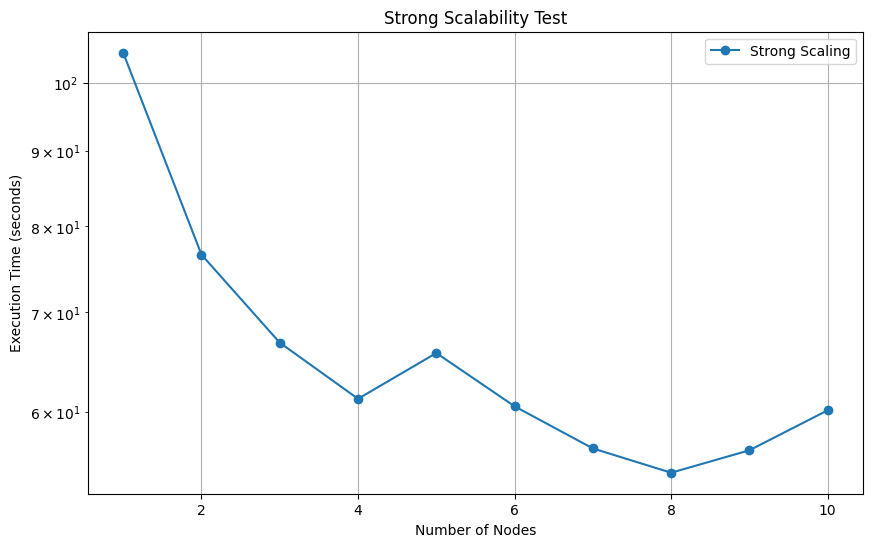

In [12]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.plot(strong_scaling_nodes, execution_times_strong_scaling, label='Strong Scaling', marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Strong Scalability Test')
plt.grid(True)
plt.legend()
plt.savefig(f"{charts_folder}/scalability_plot.png") 
plt.show()

### Weak Scalability Test

In this section, we analyze the execution times for the weak scalability test. 

The weak scalability test helps us understand how the execution time changes as we increase the number of nodes while keeping the workload per node constant. Ideally, the execution time should remain constant with the increase in the number of nodes, indicating efficient parallelization and resource utilization.

In [ ]:
# execution_times_weak_scaling = []

# # Submit jobs for each test configuration
# for num_nodes in weak_scaling_nodes:
#     execution_time_file = f"{data_folder}/weak_scaling/run_0/nodes_{num_nodes}_forecasters_{weak_scaling_forecasters*num_nodes}/timings.txt"

#     with open(execution_time_file, "r") as f:
#         line = f.readline().strip()
#         execution_time = float(line.replace("Total execution time: ", ""))
#     execution_times_weak_scaling.append(execution_time)

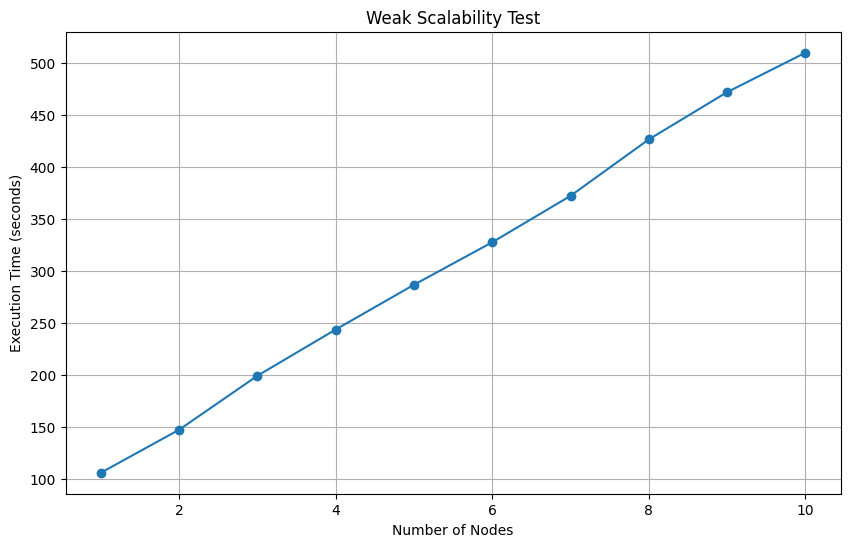

In [ ]:

# # Plot the weak scalability results
# plt.figure(figsize=(10, 6))
# plt.plot(weak_scaling_nodes, execution_times_weak_scaling, label='Weak Scaling', marker='o')
# plt.xlabel("Number of Nodes")
# plt.ylabel("Execution Time (seconds)")
# plt.title("Weak Scalability Test")
# plt.grid(True)
# plt.savefig(f"{charts_folder}/weak_scalability.png")
# plt.show()

### Conclusion

In this notebook, we have successfully set up and executed a series of scalability tests for an ensemble of forecasters in a high-performance computing environment. We started by importing the necessary libraries and setting up the directory structure. We then defined functions to submit jobs for one million forecasters, strong scaling, and weak scaling tests.

We visualized the data generated from the one million forecasters test, analyzing the distribution of forecast, weights, and biases. The histograms confirmed that these variables are normally distributed, as expected.

The strong scalability test demonstrated how the execution time decreases with an increasing number of nodes, indicating efficient parallelization. The weak scalability test showed that the execution time remains relatively constant as the number of nodes increases, suggesting good resource utilization.

Overall, these tests provide valuable insights into the performance and scalability of our forecasting ensemble, helping us optimize and improve our high-performance computing workflows.